# Example 1 

In [1]:
# pyAPEP package import
import pyapep.isofit as isofit
import pyapep.simide as simide

# Data treatment package import
import numpy as np
import pandas as pd
import copy

# Data visualization package import
import matplotlib.pyplot as plt

In [6]:
# Data import
# adsorbent 1
Data_zeo13 = pd.read_csv('Usage & casestudies/Casestudy1_Zeolite13X.csv')
# adsorbent 2
Data_ac = pd.read_csv('Usage & casestudies/Casestudy1_Activated_carbon.csv')
# adsorbent 3
Data_zeo5 = pd.read_csv('Usage & casestudies/Casestudy1_Zeolite5A.csv')

Data = [Data_zeo13, Data_ac, Data_zeo5]

In [7]:
# Find best isotherm function, Ideal PSA simulation
Adsorbent = ['Zeolite13X','Activated_carbon', 'Zeolite5A']
iso_pure = []
for i in range(3):
    ads = Data[i]
    
    P_N2 = ads['Pressure_N2 (bar)'].dropna().values
    q_N2 = ads['Uptake_N2 (mol/kg)'].dropna().values

    P_H2 = ads['Pressure_H2 (bar)'].dropna().values
    q_H2 = ads['Uptake_H2 (mol/kg)'].dropna().values
    
    N2_iso, _, _, _ = isofit.best_isomodel(P_N2, q_N2)
    H2_iso, _, _, _ = isofit.best_isomodel(P_H2, q_H2)

    iso_pure.append([N2_iso, H2_iso])

In [8]:
iso_mix_list = []
for i in range(3):
    N2_iso_ = lambda P,T: iso_pure[i][0](P)
    H2_iso_ = lambda P,T: iso_pure[i][1](P)
    
    iso_mix = lambda P,T : isofit.IAST([N2_iso_, H2_iso_], P, T)
    
    iso_mix_app = copy.deepcopy(iso_mix)
    iso_mix_list.append(iso_mix_app)

In [9]:
results = []
for i in range(3):
    iso_mix = iso_mix_list[i]
    
    CI1 = simide.IdealColumn(2, iso_mix )

    # Feed condition setting
    P_feed = 8      # Feed presure (bar)
    T_feed = 293.15    # Feed temperature (K)
    y_feed = [1/4, 3/4] # Feed mole fraction (mol/mol)
    CI1.feedcond(P_feed, T_feed, y_feed)

    # Operating condition setting
    P_high = 8 # High pressure (bar)
    P_low  = 1 # Low pressure (bar)
    CI1.opercond(P_high, P_low)

    # Simulation run
    x_tail = CI1.runideal()
    R = 1- (y_feed[0]*(1-x_tail[0]))/(x_tail[0]*(1-y_feed[0]))
    print(R*100)       # Output: [x_H2, x_N2]
    results.append(R*100)

90.97878147114302
83.41420765092575
88.39914789168635


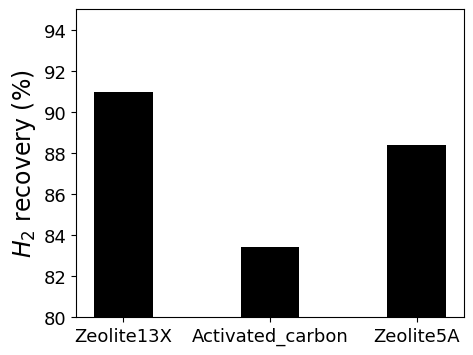

In [10]:
# Results plot
Adsorbent = ['Zeolite13X','Activated_carbon', 'Zeolite5A']
plt.figure(dpi=100, figsize=(5, 4))
plt.bar(Adsorbent, results, width=0.4, color='black')
plt.ylim([80, 95])
plt.ylabel('$H_2$ recovery (%)', fontsize=17)
plt.yticks(fontsize=13)
plt.xticks( fontsize=13)
plt.show()

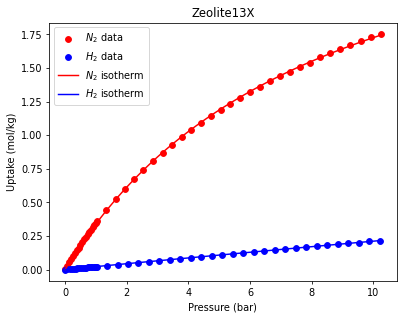

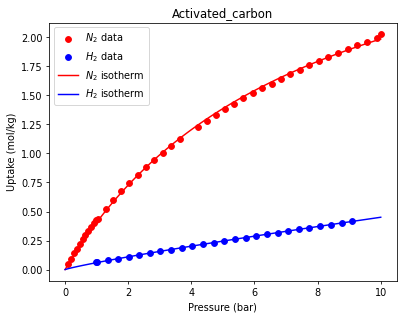

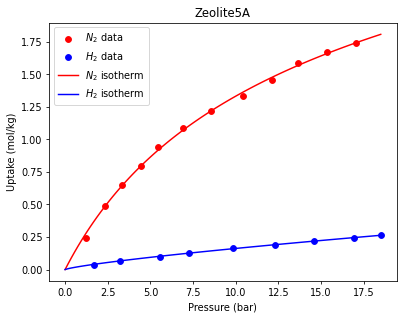

In [11]:
# Visualization ==> SI?
for i in range(3):
    ads = Data[i]
    
    P_N2 = ads['Pressure_N2 (bar)'].dropna().values
    q_N2 = ads['Uptake_N2 (mol/kg)'].dropna().values

    P_H2 = ads['Pressure_H2 (bar)'].dropna().values
    q_H2 = ads['Uptake_H2 (mol/kg)'].dropna().values
    
    plt.figure(dpi=70)
    plt.scatter(P_N2, q_N2, color = 'r')
    plt.scatter(P_H2, q_H2, color = 'b')
    
    P_max= max(max(P_N2), max(P_H2))
    P_dom = np.linspace(0, P_max, 100)
    plt.plot(P_dom, iso_pure[i][0](P_dom), color='r' )
    plt.plot(P_dom, iso_pure[i][1](P_dom), color='b' )
    
    plt.xlabel('Pressure (bar)')
    plt.ylabel('Uptake (mol/kg)')
    plt.title(f'{Adsorbent[i]}')
    plt.legend(['$N_2$ data', '$H_2$ data',
                '$N_2$ isotherm','$H_2$ isotherm'], loc='best')
    
    plt.show()

In [ ]:
# Data set 생성



# train-test split



# model define


# model training


# model evaluation



# Example 2

In [1]:
# pyAPEP package import
import pyapep.isofit as isofit
import pyapep.simsep as simsep

# Data treatment package import
import numpy as np
import pandas as pd

# Data visualization package import
import matplotlib.pyplot as plt

In [2]:
# Data import
Data = pd.read_csv('Example2_Zeolite13X.csv')

In [3]:
P_CO2 = Data['Pressure_CO2 (bar)'].dropna().values
q_CO2 = Data['Uptake_CO2 (mol/kg)'].dropna().values

P_CH4 = Data['Pressure_CH4 (bar)'].dropna().values
q_CH4 = Data['Uptake_CH4 (mol/kg)'].dropna().values

CO2_iso, CO2_p, CO2_name, CO2_err = isofit.best_isomodel(P_CO2, q_CO2)
CH4_iso, CH4_p, CO2_p, CH4_err = isofit.best_isomodel(P_CH4, q_CH4)
CO2_iso_ = lambda P,T: CO2_iso(P)
CH4_iso_ = lambda P,T: CH4_iso(P)


In [4]:
#둘다 ==> dualsite langmuir

def MixIso(P, T):
    q1 = CO2_iso(P[0])
    q2 = CH4_iso(P[1])
    return q1, q2

In [5]:
# Define column
N = 21
L = 1.35
A_cros = np.pi*0.15**2
CR1 = simsep.column(L, A_cros, n_component=2, N_node = N)

In [6]:
### Sorbent prop
voidfrac = 0.37      # (m^3/m^3)
D_particle = 12e-4   # (m)
rho = 1324           # (kg/m^3)
CR1.adsorbent_info(MixIso, voidfrac, D_particle, rho)

### Gas prop
Mmol = [0.044, 0.016] # kg/mol
mu_visco= [16.13E-6, 11.86E-6]   # (Pa sec) 
CR1.gas_prop_info(Mmol, mu_visco)
# https://www.engineeringtoolbox.com/methane-dynamic-kinematic-viscosity-temperature-pressure-d_2068.html?vA=313&degree=K#
# https://www.engineeringtoolbox.com/carbon-dioxide-dynamic-kinematic-viscosity-temperature-pressure-d_2074.html

### Transfer prop
k_MTC  = [1E-2, 1E-2]     # m/sec==============> 값필요

a_surf = 1 #Volumatric specific surface area (m2/m3)==============> 값필요 
D_disp = [1E-2, 1E-2]     # m^2/sec ==============> 값필요 
CR1.mass_trans_info(k_MTC, a_surf, D_disp)

dH_ads = [31.164e3,20.856e3]   # J/mol
Cp_s = 900
Cp_g = [38.236, 35.8]  # J/mol/K
# https://www.engineeringtoolbox.com/carbon-dioxide-d_974.html
# https://www.engineeringtoolbox.com/methane-d_1420.html

h_heat = 100            # J/m2/K/s==============> 값필요 
CR1.thermal_info(dH_ads, Cp_s, Cp_g, h_heat)

## Adsorption

In [7]:
### Operating conditions
P_inlet = 9.5
P_outlet = 9
T_feed = 323
y_feed = [0.33,0.67]

Cv_inlet = 0.2E-1             # inlet valve constant (m/sec/bar)
Cv_outlet= 2.0E-1           # outlet valve constant (m/sec/bar)

Q_feed = 0.05*A_cros  # volumetric flowrate (m^3/sec)

CR1.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed,
                   Cv_inlet, Cv_outlet,
                   Q_inlet = Q_feed,
                   assigned_v_option = True,
                   foward_flow_direction = True)

In [8]:
### Initial conditions
P_init = 9.25*np.ones(N)    # (bar)
y_init = [0.001*np.ones(N), 0.999*np.ones(N)] # (mol/mol)
T_init = T_feed*np.ones(N)
q_init = MixIso(P_init*np.array(y_init), T_init)

CR1.initialC_info(P_init, T_init, T_init, y_init, q_init)
print(CR1)

[[Current information included here]] 
Design          : True
adsorbent_info  : True
gas_prop_info   : True
mass_trans_info : True
thermal_info    : True
boundaryC_info  : True
initialC_info   : True
Flow direction  : Foward
Assigned velocity option: True



In [9]:
y_res, z_res, t_res = CR1.run_mamoen(800,n_sec = 20, 
                                    CPUtime_print = True)

Simulation of this step is completed.
This took     0.418 mins to run. 



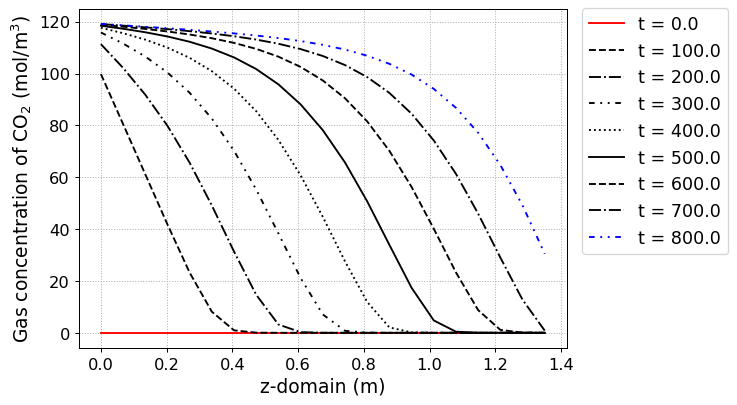

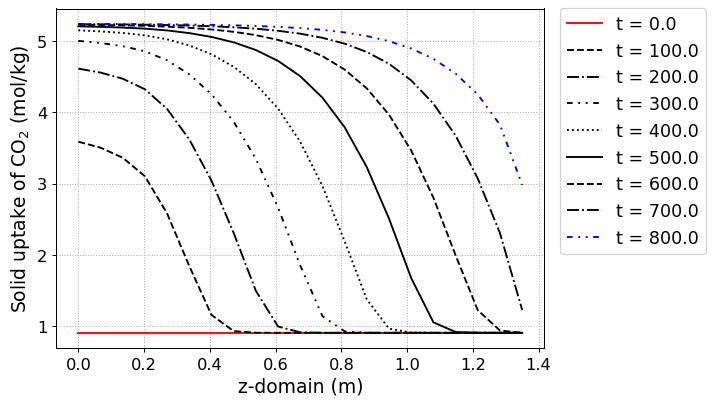

In [10]:
fig = CR1.Graph(100, 0, loc=[1.17,0.9], 
               yaxis_label = 'Gas concentration of CO$_2$ (mol/m$^3$)',)
            #    file_name = f'CO2_gas_conc_test.png')
fig = CR1.Graph(100, 2, loc=[1.17,0.9], 
               yaxis_label = 'Solid uptake of CO$_2$ (mol/kg)',)
            #    file_name = f'CH4_gas_conc_test.png')

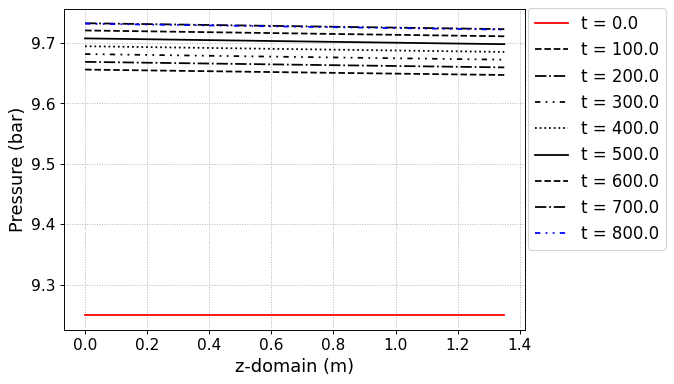

In [11]:
fig, ax = CR1.Graph_P(100, loc=[1.15,0.9])

## Blowdown

In [12]:
import copy

CR2 = copy.deepcopy(CR1)
CR2.next_init()
CR2.change_init_node(11)

### Operating conditions
P_inlet = 9
P_outlet = 1
T_feed = 323
y_feed = [0.001,0.999]

Cv_inlet = 0E-1             # inlet valve constant (m/sec/bar)
Cv_outlet= 1E-1           # outlet valve constant (m/sec/bar)

CR2.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed,
                   Cv_inlet, Cv_outlet,
                   foward_flow_direction = False)
print(CR2)

[[Current information included here]] 
Design          : True
adsorbent_info  : True
gas_prop_info   : True
mass_trans_info : True
thermal_info    : True
boundaryC_info  : True
initialC_info   : True
Flow direction  : Backward
Assigned velocity option: False



In [13]:
y_res = CR2.run_mamoen(1000,n_sec = 10, 
                                    CPUtime_print = True)

Simulation of this step is completed.
This took     0.084 mins to run. 



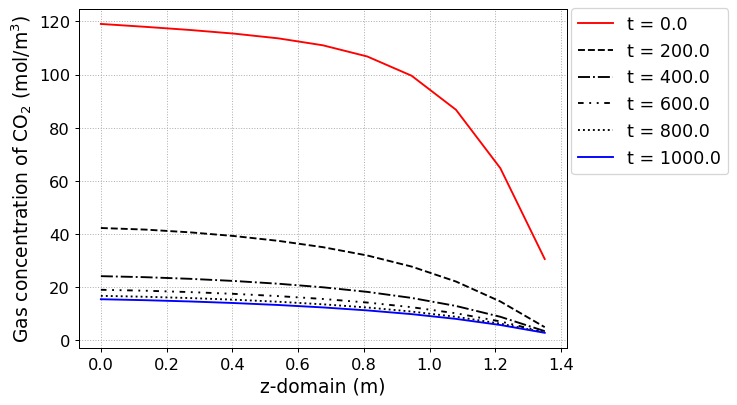

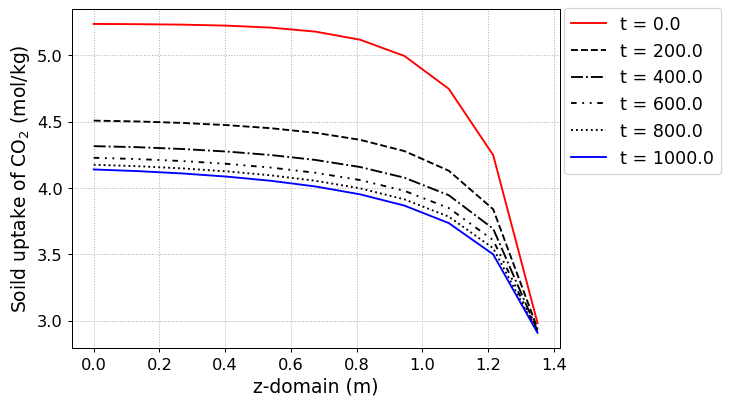

In [14]:
fig = CR2.Graph(200, 0, loc=[1.17,0.9], 
               yaxis_label = 'Gas concentration of CO$_2$ (mol/m$^3$)',)
            #    file_name = f'CO2_gas_conc_test.png')
fig = CR2.Graph(200, 2, loc=[1.17,0.9], 
               yaxis_label = 'Soild uptake of CO$_2$ (mol/kg)',)
            #    file_name = f'CH4_gas_conc_test.png')

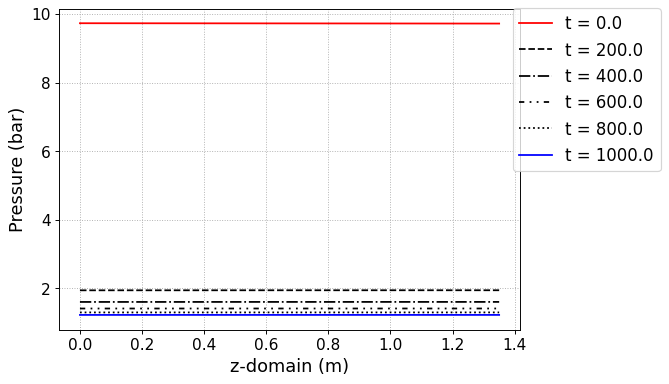

In [15]:
fig, ax = CR2.Graph_P(200, loc=[1.15,0.9])

## Purge

In [16]:
CR3 = copy.deepcopy(CR2)
CR3.next_init()

### Operating conditions
P_inlet = 1.5
P_outlet = 1
T_feed = 323
y_feed = [0.001,0.999]

Cv_inlet = 1E-1             # inlet valve constant (m/sec/bar)
Cv_outlet= 4E-1           # outlet valve constant (m/sec/bar)

CR3.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed,
                   Cv_inlet, Cv_outlet,
                   foward_flow_direction = False)
print(CR3)

[[Current information included here]] 
Design          : True
adsorbent_info  : True
gas_prop_info   : True
mass_trans_info : True
thermal_info    : True
boundaryC_info  : True
initialC_info   : True
Flow direction  : Backward
Assigned velocity option: False



In [17]:
y_res = CR3.run_mamoen(1000,n_sec = 10, 
                                    CPUtime_print = True)

Simulation of this step is completed.
This took     0.033 mins to run. 



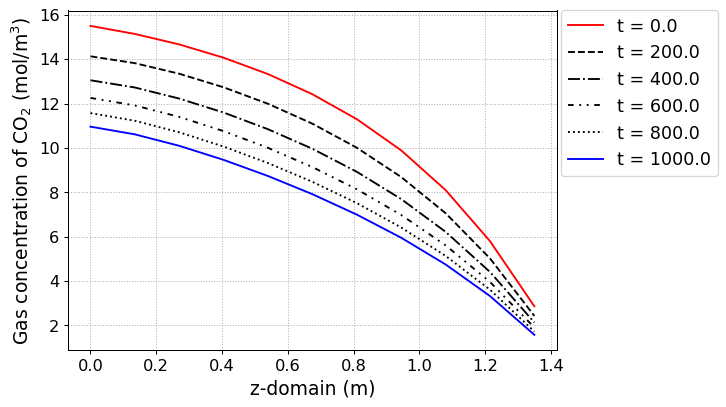

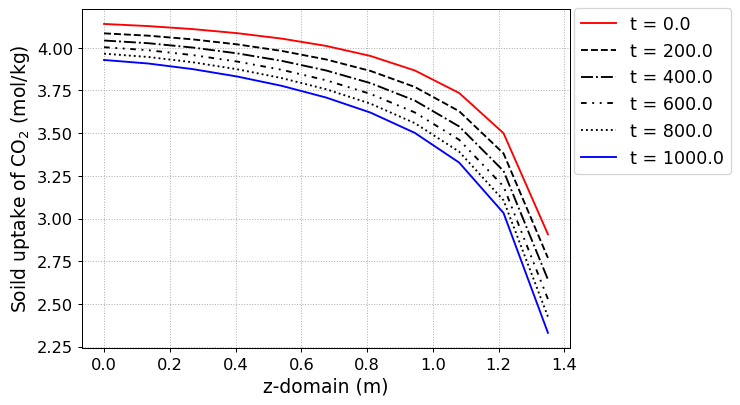

In [18]:
fig = CR3.Graph(200, 0, loc=[1.17,0.9], 
               yaxis_label = 'Gas concentration of CO$_2$ (mol/m$^3$)',)
            #    file_name = f'CO2_gas_conc_test.png')
fig = CR3.Graph(200, 2, loc=[1.17,0.9], 
               yaxis_label = 'Soild uptake of CO$_2$ (mol/kg)',)
            #    file_name = f'CH4_gas_conc_test.png')

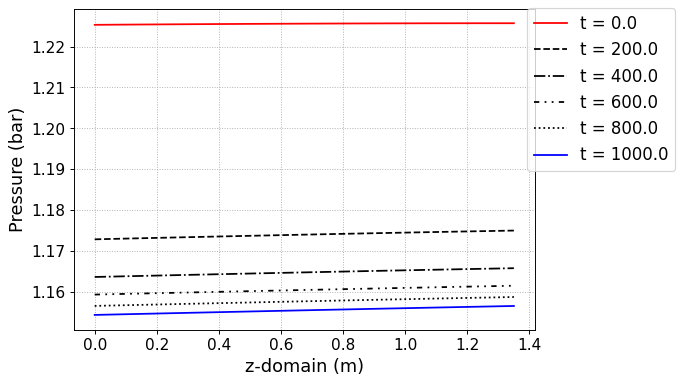

In [19]:
fig, ax = CR3.Graph_P(200, loc=[1.15,0.9])

## Pressurization

In [31]:
N = 11
R_gas = 8.3145      # 8.3145 J/mol/K

total_y = []
CR4 = copy.deepcopy(CR3)
CR4.next_init()
P_outlet = 1
P_inlet = 2
while P_outlet<8.1:
    ### Operating conditions
    T_feed = 323
    y_feed = [0.33,0.67]

    Cv_inlet =(P_inlet-P_outlet)*0.1             # inlet valve constant (m/sec/bar)
    Cv_outlet= 0E-1           # outlet valve constant (m/sec/bar)

    CR4.boundaryC_info(P_outlet, P_inlet, T_feed, y_feed,
                    Cv_inlet, Cv_outlet,
                    foward_flow_direction = True)
    y_res = CR4.run_mamoen(5,n_sec = 10, 
                                    CPUtime_print = True)
    total_y.append(y_res)
    
    P = np.zeros(N)
    for ii in range(2):
        Tg_res = y_res[0][:,2*2*N : 2*2*N+N]
        P = P + y_res[0][:,(ii)*N:(ii+1)*N]*R_gas*Tg_res/1E5
        
    P_outlet = np.mean(P[-1])
    P_inlet = P_outlet+1.1
    # fig, ax = CR4.Graph_P(1, loc=[1.15,0.9])
    # plt.show()
    CR4.next_init()

Simulation of this step is completed.
This took     0.015 mins to run. 

Simulation of this step is completed.
This took     0.016 mins to run. 

Simulation of this step is completed.
This took     0.014 mins to run. 

Simulation of this step is completed.
This took     0.012 mins to run. 

Simulation of this step is completed.
This took     0.007 mins to run. 

Simulation of this step is completed.
This took     0.008 mins to run. 

Simulation of this step is completed.
This took     0.008 mins to run. 

Simulation of this step is completed.
This took     0.009 mins to run. 

Simulation of this step is completed.
This took     0.009 mins to run. 

Simulation of this step is completed.
This took     0.009 mins to run. 

Simulation of this step is completed.
This took     0.007 mins to run. 

Simulation of this step is completed.
This took     0.008 mins to run. 

Simulation of this step is completed.
This took     0.007 mins to run. 

Simulation of this step is completed.
This took    

In [25]:
for ii, _y in enumerate(total_y):
    if ii == 0:
        concat_y = _y[0]
    else:
        concat_y = np.concatenate([concat_y, _y[0]], axis=0)

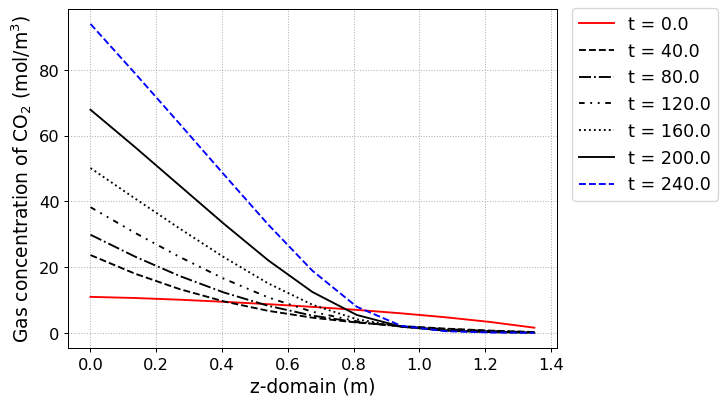

In [27]:
index = 0
fig, ax = plt.subplots(figsize = (7,5), dpi = 90)
cc= 0
lcolor = 'k'
for j in range(0,len(y), n_show):
    if j <= 1:
        lcolor = 'r'
    elif j >= len(y)-n_show:
        lcolor = 'b'
    else:
        lcolor = 'k'
    ax.plot(z_dom,y[j, index*N:(index+1)*N],
    color = lcolor, linestyle = lstyle[cc%len(lstyle)],
    label = 't = {}'.format(t_dom[j]))
    cc = cc + 1
fig.legend(fontsize = 14, bbox_to_anchor=[1.17,0.9])
ax.set_xlabel('z-domain (m)', fontsize = 15)
plt.ylabel('Gas concentration of CO$_2$ (mol/m$^3$)', fontsize=15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid(linestyle = ':')